### AirBnB Price Prediction
- C14210085 Vincent Carel
- C14210109 Ella Arminta
- C14210225 Florentina Audrina

## Setting up environment

In [1]:
# https://brilliantprogrammer.medium.com/pyspark-random-forest-regression-machine-learning-a-practical-approach-part-7-459ffff42b8b
#importing required libs
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler,VectorIndexer, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql import Window
from pyspark.sql.functions import *

In [2]:
spark = (SparkSession.builder
         .appName('myApp')
         .master('local[*]')
         .getOrCreate()
        )
sc = spark.sparkContext 

### Reading the data

In [4]:
df = spark.read.format('csv').options(header=True, inferSchema=True, sep=',', quote='"', escape='"').load('train.csv')

df_with_id = df.withColumn("unique_id", monotonically_increasing_id())
print(df_with_id.count())
dfcol1 = df_with_id.select("unique_id", *df.columns[:10])
dfcol1.show()
dfcol2 = df_with_id.select("unique_id", *df.columns[10:19])
dfcol2.show()
dfcol3 = df_with_id.select("unique_id", *df.columns[19:27])
dfcol3.show()
dfcol4 = df_with_id.select("unique_id", *df.columns[27:])
dfcol4.show()

print('dfcol1',dfcol1.count())
print('dfcol2',dfcol2.count())
print('dfcol3',dfcol3.count())
print('dfcol4',dfcol4.count())


df_with_id.printSchema()

74113
+---------+--------+------------------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+
|unique_id|      id|         log_price|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|
+---------+--------+------------------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+
|        0| 6901257| 5.010635294096256|    Apartment|Entire home/apt|{"Wireless Intern...|           3|      1.0|Real Bed|             strict|        true|
|        1| 6304928|5.1298987149230735|    Apartment|Entire home/apt|{"Wireless Intern...|           7|      1.0|Real Bed|             strict|        true|
|        2| 7919400| 4.976733742420574|    Apartment|Entire home/apt|{TV,"Cable TV","W...|           5|      1.0|Real Bed|           moderate|        true|
|        3|13418779| 6.620073206530356|        House|Entir

## EDA

### Cleaning Data - Replace Null Value

In [5]:
# Missing Value
columns_to_check = [c for c in df.columns if c not in  ['cleaning_fee','first_review','host_since','last_review']]
df.select([count(when(col(c).isNull() | isnan(c), 1)).alias(c) for c in columns_to_check]).show(vertical=True)
dftemp = df.select(['cleaning_fee','first_review','host_since','last_review'])

dftemp.select([count(when(col(c).isNull(), 1)).alias(c) for c in dftemp.columns]).show()

-RECORD 0-----------------------
 id                     | 0     
 log_price              | 0     
 property_type          | 0     
 room_type              | 2     
 amenities              | 2     
 accommodates           | 2     
 bathrooms              | 202   
 bed_type               | 2     
 cancellation_policy    | 2     
 city                   | 2     
 description            | 2     
 host_has_profile_pic   | 190   
 host_identity_verified | 190   
 host_response_rate     | 18301 
 instant_bookable       | 2     
 latitude               | 2     
 longitude              | 2     
 name                   | 2     
 neighbourhood          | 6874  
 number_of_reviews      | 2     
 review_scores_rating   | 16724 
 thumbnail_url          | 8218  
 zipcode                | 968   
 bedrooms               | 95    
 beds                   | 135   

+------------+------------+----------+-----------+
|cleaning_fee|first_review|host_since|last_review|
+------------+------------+----------+-

#### Clean dfcol1

In [6]:
# mereplace null value bathroom
dfcol1bathrooms = dfcol1 \
    .groupBy(['property_type', 'room_type', 'accommodates', 'bathrooms']) \
    .agg(count('bathrooms').alias('bathroom_count')) \
    .sort('property_type', 'room_type', 'accommodates')

# delete row dimana bathroom null
dfcol1bathrooms = dfcol1bathrooms.dropna(subset=['bathrooms'])

# max bathroom count per groupby
max_bathroom_count_df = dfcol1bathrooms \
    .groupBy(['property_type', 'room_type', 'accommodates']) \
    .agg(max('bathroom_count').alias('max_bathroom_count'))

# join database bathrooms dengan max bathrooms
dfcol1bathrooms = dfcol1bathrooms \
    .join(max_bathroom_count_df, on=['property_type', 'room_type', 'accommodates'], how="left") \
    .filter(dfcol1bathrooms['bathroom_count'] == max_bathroom_count_df['max_bathroom_count']) \
    .drop('max_bathroom_count')

dfcol1bathrooms = dfcol1bathrooms.withColumn('bathrooms_predicted', col('bathrooms'))
dfcol1bathrooms = dfcol1bathrooms.groupBy(['property_type', 'room_type', 'accommodates','bathroom_count']).agg(count('bathroom_count').alias('count_row'), avg(col('bathrooms_predicted')).alias('avg_bathrooms_predicted'))
dfcol1bathrooms = dfcol1bathrooms.drop('bathrooms')
print('dfcol1bathrooms',dfcol1bathrooms.count())
dfcol1bathrooms.show()

print('dfcol1 1',dfcol1.count())
dftemp = dfcol1.join(dfcol1bathrooms, on=['property_type', 'room_type', 'accommodates'], how='left')
print('dftemp1',dftemp.count())
# dftemp.show()
dftemp = dftemp.withColumn(
    'bathrooms',
    when(col('bathrooms').isNull(), col('avg_bathrooms_predicted')).otherwise(col('bathrooms'))
)
dftemp = dftemp.drop('avg_bathrooms_predicted','bathroom_count','count_row')
dftemp = dftemp.filter(dftemp['bathrooms'].isNotNull())
dftemp.where(dftemp['bathrooms'].isNull()).show()
dftemp.select([count(when(col(c).isNull(), 1)).alias(c) for c in dftemp.columns]).show()
print('dftemp2',dftemp.count())
dfcol1 = dftemp
dfcol1.drop('amenities')
dfcol1.show()
print(dfcol1.count())

dfcol1bathrooms 451
+--------------+---------------+------------+--------------+---------+-----------------------+
| property_type|      room_type|accommodates|bathroom_count|count_row|avg_bathrooms_predicted|
+--------------+---------------+------------+--------------+---------+-----------------------+
|        Hostel|    Shared room|           4|             1|        2|                   4.75|
|         Villa|   Private room|           4|             9|        1|                    1.0|
|   Condominium|   Private room|           7|             2|        1|                    2.0|
|         House|Entire home/apt|           7|           114|        1|                    2.0|
|          Tent|   Private room|           4|             1|        1|                    0.0|
|        In-law|   Private room|           4|             2|        1|                    1.0|
|     Apartment|    Shared room|           4|            39|        1|                    1.0|
|          Yurt|Entire home/ap

#### Preprocess dfcol1

In [7]:
# dfcol1.show()
dfcol1.printSchema()
dfcol1 = dfcol1.drop(*['id','amenities'])
dfcol1 = dfcol1.withColumn('cleaning_fee_idx', when(col('cleaning_fee') == 'true', 1).otherwise(0))
dfcol1 = dfcol1.withColumn('cancellation_policy_idx', when(col('cancellation_policy') == 'flexible', 0).otherwise(when(col('cancellation_policy') == 'moderate', 1).otherwise(2)))
dfcol1.printSchema()
dfcol1.show()

root
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- unique_id: long (nullable = false)
 |-- id: string (nullable = true)
 |-- log_price: double (nullable = true)
 |-- amenities: string (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)

root
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- unique_id: long (nullable = false)
 |-- log_price: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)
 |-- cleaning_fee_idx: integer (nullable = false)
 |-- cancellation_policy_idx: integer (nullable = false)

+---------------+-----------

In [8]:
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(dfcol1) for col in ['property_type','room_type','bed_type']]
pipeline = Pipeline(stages=indexers)
dfcol1 = pipeline.fit(dfcol1).transform(dfcol1)
dfcol1.show()

+---------------+---------------+------------+---------+------------------+---------+--------+-------------------+------------+----------------+-----------------------+-----------------+-------------+------------+
|  property_type|      room_type|accommodates|unique_id|         log_price|bathrooms|bed_type|cancellation_policy|cleaning_fee|cleaning_fee_idx|cancellation_policy_idx|property_type_idx|room_type_idx|bed_type_idx|
+---------------+---------------+------------+---------+------------------+---------+--------+-------------------+------------+----------------+-----------------------+-----------------+-------------+------------+
|         Hostel|   Private room|           3|     1629| 4.700480365792417|      1.0|Real Bed|           flexible|       false|               0|                      0|             16.0|          1.0|         0.0|
|Bed & Breakfast|    Shared room|           2|     1152|4.0943445622220995|      1.0|Real Bed|           flexible|        true|               1|

In [9]:
dfcol1 = dfcol1.select(['unique_id','log_price','accommodates','bathrooms','cleaning_fee_idx','cancellation_policy_idx','property_type_idx','room_type_idx','bed_type_idx'])
dfcol1.show()

+---------+------------------+------------+---------+----------------+-----------------------+-----------------+-------------+------------+
|unique_id|         log_price|accommodates|bathrooms|cleaning_fee_idx|cancellation_policy_idx|property_type_idx|room_type_idx|bed_type_idx|
+---------+------------------+------------+---------+----------------+-----------------------+-----------------+-------------+------------+
|     1629| 4.700480365792417|           3|      1.0|               0|                      0|             16.0|          1.0|         0.0|
|     1152|4.0943445622220995|           2|      1.0|               1|                      0|              7.0|          2.0|         0.0|
|     4675| 4.330733340286331|           2|      1.0|               0|                      2|              7.0|          2.0|         0.0|
|     7111|  4.23410650459726|           2|      0.0|               0|                      0|              7.0|          2.0|         0.0|
|      181| 4.941642

### Clean dfcol2 & Preprocess

In [10]:
# dfcol2
# column list:
# city|description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review

# column tambahan: years_as_host,city_idx
# column yang didrop: city, first_review, host_since, last_review
# preprocessing
# 1
# Convert 't' to 1 and 'f' to 0
dfcol2 = dfcol2.withColumn('host_has_profile_pic', when(col('host_has_profile_pic') == 't', 1).otherwise(0))
dfcol2 = dfcol2.withColumn('host_identity_verified', when(col('host_identity_verified') == 't', 1).otherwise(0))
dfcol2 = dfcol2.withColumn('instant_bookable', when(col('instant_bookable') == 't', 1).otherwise(0))
dfcol2.show()

+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+
|unique_id|   city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|
+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+
|        0|    NYC|Beautiful, sunlit...|  2016-06-18|                   1|                     1|              NULL|2012-03-26|               0| 2016-07-18|
|        1|    NYC|Enjoy travelling ...|  2017-08-05|                   1|                     0|              100%|2017-06-19|               1| 2017-09-23|
|        2|    NYC|The Oasis comes c...|  2017-04-30|                   1|                     1|              100%|2016-10-25|               1| 2017-09-14|
|        3|     SF|This light-filled...|        NULL|     

In [11]:
# 2
# Convert host_response_rate to float
dfcol2 = dfcol2.withColumn('host_response_rate', 
                   regexp_replace('host_response_rate', '%', '').cast('float') / 100)

# Calculate the average host_response_rate
average_rate = dfcol2.select(avg(col('host_response_rate'))).collect()[0][0]

# Fill null values with the average rate
dfcol2 = dfcol2.withColumn('host_response_rate', when(col('host_response_rate').isNull(), average_rate).otherwise(col('host_response_rate')))
dfcol2.show()

+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+
|unique_id|   city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|
+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+
|        0|    NYC|Beautiful, sunlit...|  2016-06-18|                   1|                     1|0.9435196731885569|2012-03-26|               0| 2016-07-18|
|        1|    NYC|Enjoy travelling ...|  2017-08-05|                   1|                     0|               1.0|2017-06-19|               1| 2017-09-23|
|        2|    NYC|The Oasis comes c...|  2017-04-30|                   1|                     1|               1.0|2016-10-25|               1| 2017-09-14|
|        3|     SF|This light-filled...|        NULL|     

In [12]:
# 3
# Get the current year
current_year = 2024

# Extract the year from 'host_since' and calculate 'years_as_host'
dfcol2 = dfcol2.withColumn('years_as_host', current_year - year(col('host_since')))

In [13]:
# 4
# fill misssing values for CITY

dfcol2 = dfcol2.fillna({'city' : 'NYC'})
dfcol2.show()

+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+-------------+
|unique_id|   city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|years_as_host|
+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+-------------+
|        0|    NYC|Beautiful, sunlit...|  2016-06-18|                   1|                     1|0.9435196731885569|2012-03-26|               0| 2016-07-18|           12|
|        1|    NYC|Enjoy travelling ...|  2017-08-05|                   1|                     0|               1.0|2017-06-19|               1| 2017-09-23|            7|
|        2|    NYC|The Oasis comes c...|  2017-04-30|                   1|                     1|               1.0|2016-10-25|               1| 

In [14]:
# 5
dfcol2 = dfcol2.drop('description','first_review', 'host_since', 'last_review')

In [15]:
# 6
# changing city to numerical
indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(df) for col in ['city']]

pipeline = Pipeline(stages=indexers) #optional
dfcol2 = pipeline.fit(dfcol2).transform(dfcol2).drop('city')
dfcol2.show()

+---------+--------------------+----------------------+------------------+----------------+-------------+--------+
|unique_id|host_has_profile_pic|host_identity_verified|host_response_rate|instant_bookable|years_as_host|city_idx|
+---------+--------------------+----------------------+------------------+----------------+-------------+--------+
|        0|                   1|                     1|0.9435196731885569|               0|           12|     0.0|
|        1|                   1|                     0|               1.0|               1|            7|     0.0|
|        2|                   1|                     1|               1.0|               1|            8|     0.0|
|        3|                   1|                     1|0.9435196731885569|               0|            9|     2.0|
|        4|                   1|                     1|               1.0|               1|            9|     3.0|
|        5|                   1|                     1|               1.0|      

## DF Final

In [16]:
print('dfcol1',dfcol1.count())
print('dfcol2',dfcol2.count())
print('dfcol2',dfcol3.count())
print('dfcol2',dfcol4.count())

dfcolfinal = dfcol1.join(dfcol2, on="unique_id", how="inner") \
                   # .join(dfcol3, on="unique_id", how="inner") \
                   # .join(dfcol4, on="unique_id", how="inner") \

print('dfcolfinal',dfcolfinal.count())
# intersection_ids = dfcol1.select("unique_id") \
#     .intersect(dfcol2.select("unique_id")) \
#     # .intersect(dfcol3.select("unique_id")) \
#     # .intersect(dfcol4.select("unique_id"))

# # Filter the original DataFrame with these intersection IDs
# dfcolfinal = df_with_id.join(intersection_ids, on="unique_id").drop("unique_id")

# Show the final DataFrame
dfcolfinal.show()

dfcol1 74110
dfcol2 74113
dfcol2 74113
dfcol2 74113
dfcolfinal 74110
+---------+------------------+------------+---------+----------------+-----------------------+-----------------+-------------+------------+--------------------+----------------------+------------------+----------------+-------------+--------+
|unique_id|         log_price|accommodates|bathrooms|cleaning_fee_idx|cancellation_policy_idx|property_type_idx|room_type_idx|bed_type_idx|host_has_profile_pic|host_identity_verified|host_response_rate|instant_bookable|years_as_host|city_idx|
+---------+------------------+------------+---------+----------------+-----------------------+-----------------+-------------+------------+--------------------+----------------------+------------------+----------------+-------------+--------+
|     1629| 4.700480365792417|           3|      1.0|               0|                      0|             16.0|          1.0|         0.0|                   1|                     1|               1.0|

### Correlation Matrix

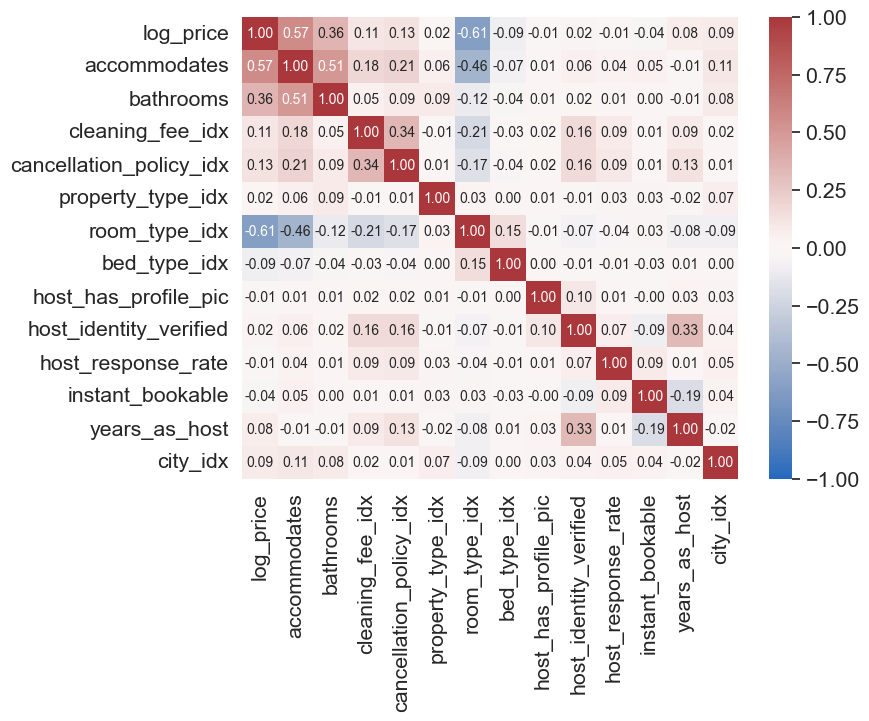

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

dfcolmatrix = dfcolfinal
dfcolmatrix = dfcolmatrix.drop('unique_id')
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
heat = sns.heatmap(data=dfcolmatrix.toPandas().corr(), cmap='vlag', vmin=-1, vmax=1,annot=True,fmt=".2f", annot_kws={"size": 10})

### Chart Log price x room_type_idx

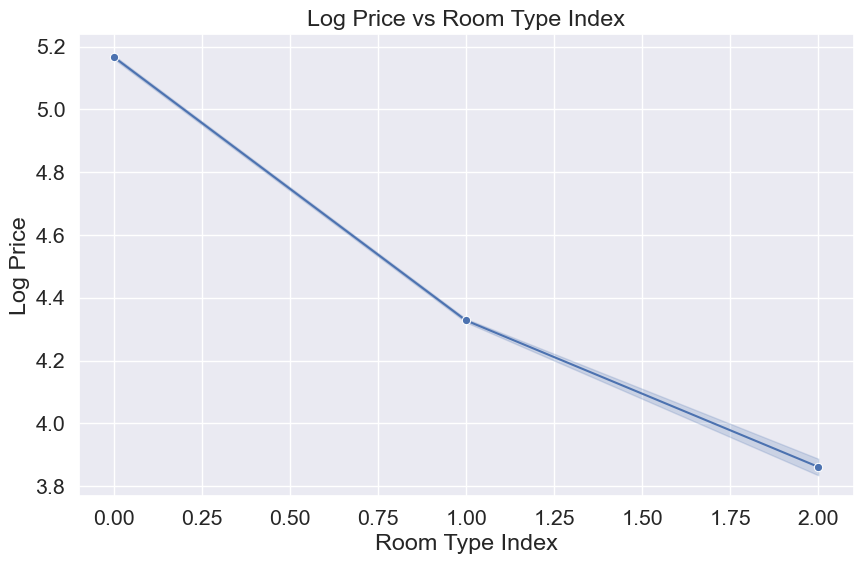

In [19]:
dflinechart = dfcolfinal.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=dflinechart, x='room_type_idx', y='log_price', marker='o')

plt.title('Log Price vs Room Type Index')
plt.xlabel('Room Type Index')
plt.ylabel('Log Price')
plt.grid(True)
plt.show()

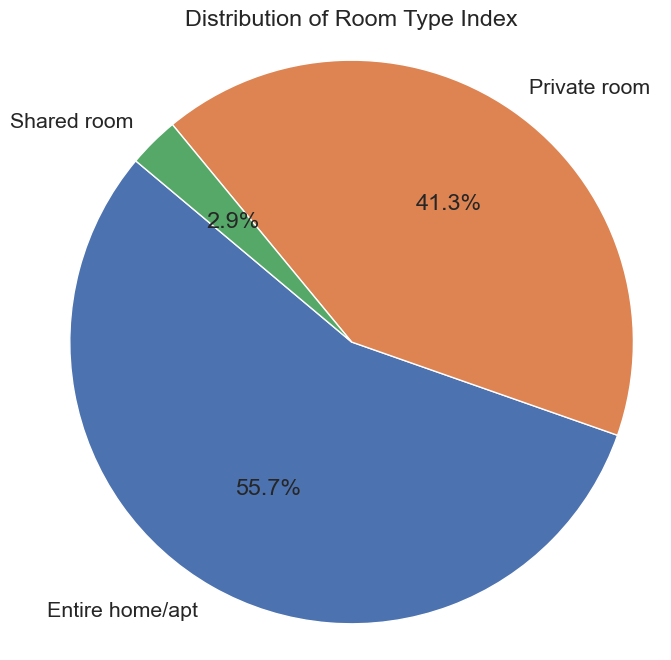

In [23]:
dfpiechartroom = dfcolfinal.toPandas()

# Count the occurrences of each unique room_type_idx
room_type_counts = dfpiechartroom['room_type_idx'].value_counts()

room_type_mapping = {
    0.0: 'Entire home/apt',
    1.0: 'Private room',
    2.0: 'Shared room',
    3.0: 'Hotel room',
}
room_type_labels = room_type_counts.index.map(room_type_mapping)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(room_type_counts, labels=room_type_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Room Type Index')
plt.axis('equal') 
plt.show()

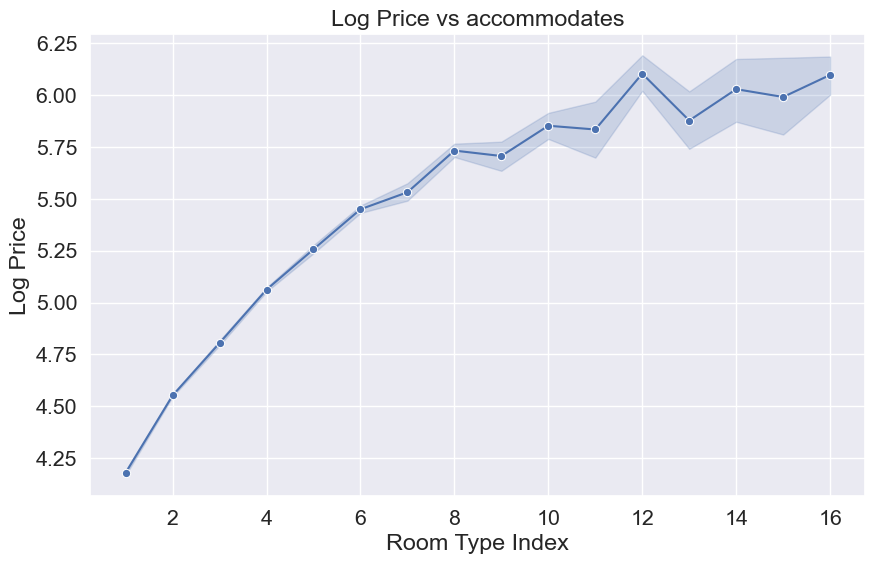

In [21]:
dflinechart = dfcolfinal.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=dflinechart, x='accommodates', y='log_price', marker='o')

plt.title('Log Price vs accommodates')
plt.xlabel('Room Type Index')
plt.ylabel('Log Price')
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

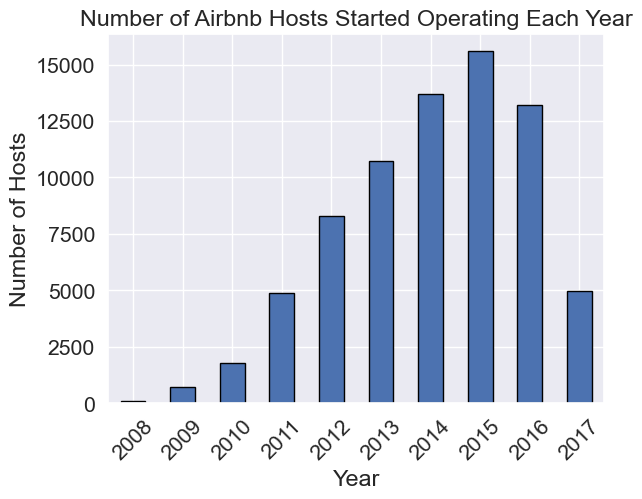

In [36]:
# Current year
current_year = 2024

# Calculate the start year
dfcolfinal_year = dfcolfinal.withColumn('start_year', current_year - col('years_as_host'))

# Drop rows with NaN values in start_year
dfcolfinal_year = dfcolfinal_year.dropna(subset=['start_year'])

# Convert start_year to integer type
dfcolfinal_year = dfcolfinal_year.withColumn('start_year', col('start_year').cast('integer'))

# Group by start_year and count the number of rows in each year
yearly_counts = dfcolfinal_year.groupBy('start_year').count()

# Convert the grouped data to a Pandas DataFrame
yearly_counts_pd = yearly_counts.orderBy('start_year').toPandas()

# Plot the histogram
plt.figure(figsize=(10, 6))
yearly_counts_pd.plot(kind='bar', x='start_year', y='count', legend=False, edgecolor='black')
plt.title('Number of Airbnb Hosts Started Operating Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Hosts')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

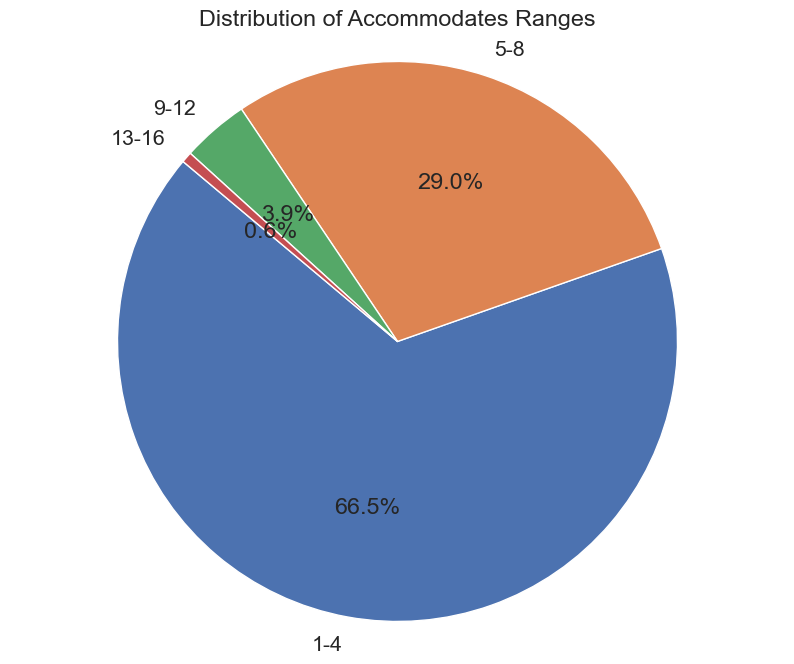

In [39]:
import pandas as pd
dfdistaccomodates = dfcolfinal.toPandas()

# Define the ranges for accommodates
bins = [0, 4, 8, 12, 16]
labels = ['1-4', '5-8', '9-12', '13-16']

# Create a new column 'accommodates_range' that groups accommodates into ranges
dfdistaccomodates['accommodates_range'] = pd.cut(dfdistaccomodates['accommodates'], bins=bins, labels=labels, right=False)

# Count the occurrences of each range
accommodates_counts = dfdistaccomodates['accommodates_range'].value_counts().sort_index()

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(accommodates_counts, labels=accommodates_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Accommodates Ranges')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

### Tuning Data

In [ ]:
## masih blm pilih parameter dan Tuning data

### Assemble all our features to one vector


In [26]:
features = dfcolfinal.select(['room_type_idx','bathrooms','accommodates'])
features.show()

+-------------+---------+------------+
|room_type_idx|bathrooms|accommodates|
+-------------+---------+------------+
|          1.0|      1.0|           3|
|          2.0|      1.0|           2|
|          2.0|      1.0|           2|
|          2.0|      0.0|           2|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.5|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
|          0.0|      1.0|           3|
+-------------+---------+------------+
only showing top 20 rows



In [27]:
assembler = VectorAssembler(inputCols=features.columns,outputCol="features")
output = assembler.transform(dfcolfinal)

### Random Forest Regressor
Class for indexing categorical feature columns in a dataset of Vector.


In [28]:
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(output)

featureIndexer = featureIndexer.transform(output)
featureIndexer
# DataFrame[features: vector, Chance of Admit: float, indexedFeatures: vector]

new_indexed_data = featureIndexer.select("indexedFeatures", "log_price")
new_indexed_data.show()

+---------------+------------------+
|indexedFeatures|         log_price|
+---------------+------------------+
|  [1.0,2.0,2.0]| 4.700480365792417|
|  [2.0,2.0,1.0]|4.0943445622220995|
|  [2.0,2.0,1.0]| 4.330733340286331|
|  [2.0,0.0,1.0]|  4.23410650459726|
|  [0.0,2.0,2.0]| 4.941642422609304|
|  [0.0,2.0,2.0]|5.5606816310155285|
|  [0.0,2.0,2.0]| 5.147494476813453|
|  [0.0,2.0,2.0]| 5.521460917862246|
|  [0.0,2.0,2.0]|5.0751738152338275|
|  [0.0,2.0,2.0]| 5.666426688112433|
|  [0.0,2.0,2.0]|  6.38856140554563|
|  [0.0,2.0,2.0]|5.1647859739235145|
|  [0.0,2.0,2.0]| 5.010635294096256|
|  [0.0,2.0,2.0]| 4.820281565605037|
|  [0.0,2.0,2.0]|5.9401712527204324|
|  [0.0,3.0,2.0]|5.3706380281276624|
|  [0.0,2.0,2.0]| 4.174387269895637|
|  [0.0,2.0,2.0]|  4.90527477843843|
|  [0.0,2.0,2.0]| 4.997212273764115|
|  [0.0,2.0,2.0]|5.5174528964647065|
+---------------+------------------+
only showing top 20 rows



### Split the Data

In [29]:
training, test = new_indexed_data.randomSplit([0.7, 0.3])

training.show()
test.show()

+---------------+------------------+
|indexedFeatures|         log_price|
+---------------+------------------+
|  [0.0,0.0,0.0]|4.3694478524670215|
|  [0.0,0.0,1.0]|2.8332133440562166|
|  [0.0,0.0,1.0]|3.8918202981106265|
|  [0.0,0.0,1.0]|  4.07753744390572|
|  [0.0,0.0,1.0]| 4.174387269895637|
|  [0.0,0.0,1.0]|  4.48863636973214|
|  [0.0,0.0,1.0]| 4.543294782270004|
|  [0.0,0.0,1.0]|  4.59511985013459|
|  [0.0,0.0,1.0]|  4.59511985013459|
|  [0.0,0.0,1.0]|  4.59511985013459|
|  [0.0,0.0,1.0]|  4.59511985013459|
|  [0.0,0.0,1.0]|  4.59511985013459|
|  [0.0,0.0,1.0]| 5.293304824724492|
|  [0.0,0.0,1.0]| 5.298317366548036|
|  [0.0,0.0,1.0]| 6.907755278982138|
|  [0.0,0.0,2.0]| 3.218875824868201|
|  [0.0,0.0,2.0]| 5.298317366548036|
|  [0.0,0.0,3.0]|  4.48863636973214|
|  [0.0,0.0,3.0]| 4.941642422609304|
|  [0.0,0.0,7.0]| 4.553876891600541|
+---------------+------------------+
only showing top 20 rows

+---------------+------------------+
|indexedFeatures|         log_price|
+-----------

### Apply Random Regressor

In [30]:
random_forest_reg = RandomForestRegressor(featuresCol="indexedFeatures",labelCol="log_price",maxBins=40)

random_forest_reg

RandomForestRegressor_70440cd74ac6

### Train Model

In [31]:
model = random_forest_reg.fit(training)

model

RandomForestRegressionModel: uid=RandomForestRegressor_70440cd74ac6, numTrees=20, numFeatures=3

### Making Prediction on test Data

In [32]:
predictions = model.transform(test)

predictions.show(400, truncate=False)

+---------------+------------------+-----------------+
|indexedFeatures|log_price         |prediction       |
+---------------+------------------+-----------------+
|[0.0,0.0,0.0]  |3.912023005428147 |4.740304818462893|
|[0.0,0.0,1.0]  |4.442651256490317 |4.778067884676024|
|[0.0,0.0,1.0]  |4.584967478670572 |4.778067884676024|
|[0.0,0.0,1.0]  |4.59511985013459  |4.778067884676024|
|[0.0,0.0,1.0]  |4.59511985013459  |4.778067884676024|
|[0.0,0.0,1.0]  |5.298317366548036 |4.778067884676024|
|[0.0,0.0,2.0]  |5.198497031265826 |4.688152777083595|
|[0.0,0.0,2.0]  |5.25227342804663  |4.688152777083595|
|[0.0,0.0,3.0]  |5.3471075307174685|4.816053873768201|
|[0.0,0.0,9.0]  |6.907755278982138 |5.480503087582321|
|[0.0,0.0,11.0] |5.634789603169249 |5.54502532850021 |
|[0.0,0.0,15.0] |4.5217885770490405|5.579225735019994|
|[0.0,1.0,0.0]  |4.605170185988092 |4.787621778354041|
|[0.0,1.0,1.0]  |4.174387269895637 |4.805533647034039|
|[0.0,1.0,1.0]  |4.174387269895637 |4.805533647034039|
|[0.0,1.0,

In [35]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")
print ("Root Mean Squared Error (RMSE) on test data = ",evaluator.evaluate(predictions), "(mendekati 0 lebih akurat)")

evaluator = RegressionEvaluator(labelCol="log_price",predictionCol="prediction", metricName="r2")
print("R Squared (R2) on test data =", evaluator.evaluate(predictions), "(mendekati 1 lebih akurat)")

# Evaluate MAE
evaluator_mae = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data = ", mae , "(mendekati 0 lebih akurat)")

# Evaluate MSE
evaluator_mse = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="mse")
mse = evaluator_mse.evaluate(predictions)
print("Mean Squared Error (MSE) on test data = ", mse , "(mendekati 0 lebih akurat)")

# Evaluate MAP
predictions_with_error = predictions.withColumn(
    'abs_pct_error', abs((col('log_price') - col('prediction')) / col('log_price'))
)
dfevalmape = predictions_with_error.select('abs_pct_error').toPandas()
mape = dfevalmape['abs_pct_error'].mean() * 100
print("Mean Absolute Percentage Error (MAPE) on test data =", mape, "% (mendekati 0% is lebih akurat)")

Root Mean Squared Error (RMSE) on test data =  0.5002907061348647 (mendekati 0 lebih akurat)
R Squared (R2) on test data = 0.5110576372157949 (mendekati 1 lebih akurat)
Mean Absolute Error (MAE) on test data =  0.3797320955586346 (mendekati 0 lebih akurat)
Mean Squared Error (MSE) on test data =  0.2502907906449216 (mendekati 0 lebih akurat)
Mean Absolute Percentage Error (MAPE) on test data = 8.029098253315894 % (mendekati 0% is lebih akurat)
